- Transformer 구조는 NLP 분야에서 높은 성능을 보이며 표준으로 자리잡는데에 반해, Computer Vision 분야에서는 아직 제한적이었음.

- Computer Vision 분야에서 Attention은 CNN에 결합해서 쓰거나, CNN의 구성 요소를 대체하는 식으로 간접적으로만 사용됨.

- 논문을 발표한 구글팀은 이미지 분야에서 CNN에 대한 의존을 끊고 Transformer를 직접적으로 사용하기 위해 image를 patch로 잘라 Sequence로서 사용하는 방식으로 이미지 분류를 수행.

- 거대한 양의 데이터셋 (ImageNet, JFT)으로 pre-train한 후, 중간 사이즈 혹은 적은 양의 이미지 데이터셋에 대해 transfer하는 방식으로 기존의 ResNet 기반의 SOTA 모델들보다 좋은 성능 & 적은 계산량을 보임.

### **1. Intro**

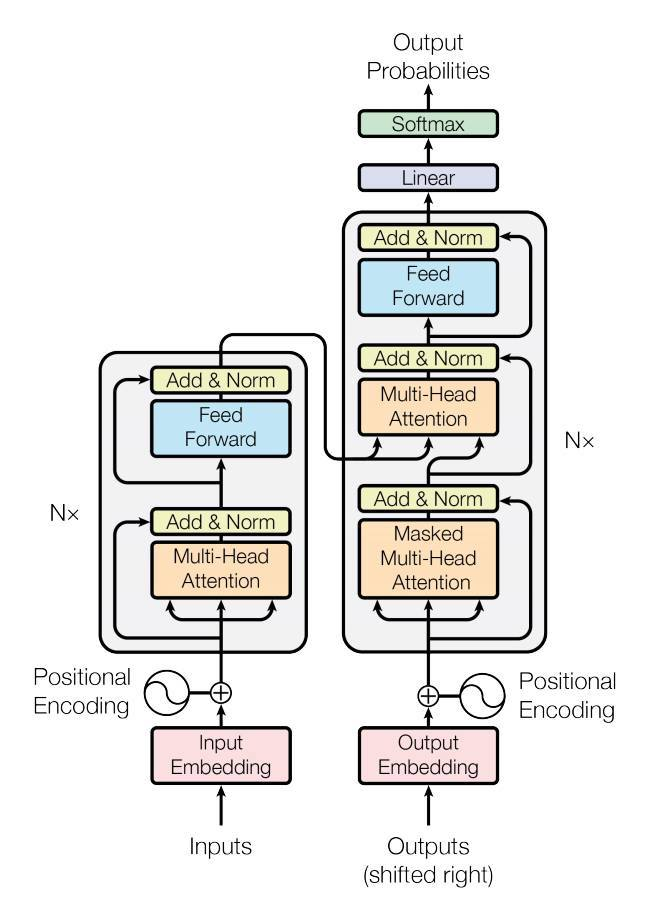

- Transformer는 Self-attention을 사용한 구조로, 자연어처리(NLP) 분야에서 높은 성능을 거두며 거의 표준으로 사용되고 있다.
- 해당 방법론은 거대한 text corpus로부터 pre-train한 후 작은 task의 데이터셋에 대해서 fine-tune하여 처리하는 방식이다.

- 특히 Transformer의 적은 계산량과 높은 확장성으로 인해, 100B가 넘어가는 막대한 parameter를 가지는 모델도 학습이 가능하게 되었습니다. 현실의 데이터셋이 점점 더 커지는 가운데 이는 현실 상황에 적합한 모델로 평가할 수 있다.

- Computer Vision 분야에서는 ViT 논문이 발표되기 전까지는 여전히 CNN 기반 모델들이 지배적이었다.

- NLP 분야에서의 성공에 힘입어, CNN 구조의 모델들에 Self-attention을 접목시키려는 노력도 있었다. 게다가 CNN 구조를 통째로 Transformer로 바꾸려는 노력도 있었는데, 이는 이론적으로는 괜찮아보이나, specialized된 attention 패턴을 보여서 계산상으로 비효율적이었다.

- 구글팀은 이러한 상황에서 거의 수정을 거치지 않은 표준 그대로의 Transformer를 이미지에 적용해보고자 했다.

- 아이디어는 다음과 같다.
> **이미지를 일정한 크기의 Patch로 나눠서, 이를 단어의 배열처럼 Sequence로 사용한다! 그렇게 한다면 이미지 패치는 NLP 분야에서 Token (Words)처럼 처리할 수 있을 것이다. 이러한 아이디어 때문인지 논문의 제목도 이미지를 16x16 단어로 표현한다.**




구글팀은 먼저 ImageNet과 같은 mid-sized 데이터셋으로 학습시켰다. 이는 ResNet 기반 모델들에 비해 살짝 안 좋은 성능을 보였다. 이러한 결과는 어떻게 보면 당연한 것이었는데. 그 이유는 바로 Inductive bias 때문이다.

여기서 Inductive bias란 주어지지 않은 입력의 출력을 예측하는 능력이다.
즉, 일반화의 성능을 높이기 위해서 만약의 상황에 대한 추가적인 가정(Additional Assumptions)으로 볼 수 있다.

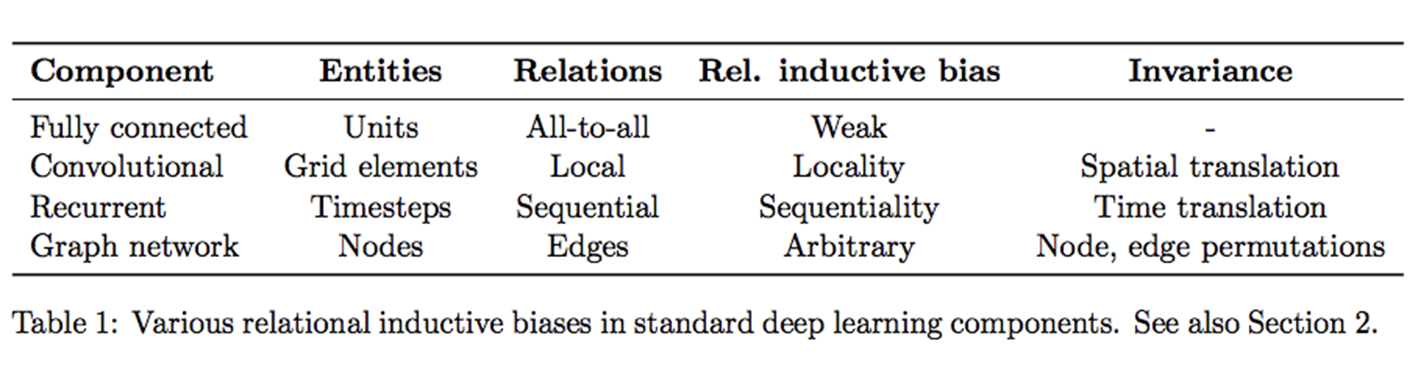

위 표에서 Fully connected layer의 경우 inductive bias가 낮고, CNN이나 RNN 계열의 경우 Relative Inductive bias가 존재하는 것을 알 수 있다.

>  inductive bias(귀납적 편향)는 기계 학습 모델에서 매우 중요한 요소이며, 적절한 inductive bias가 있어야 모델 성능이 좋아질 수 있다. inductive bias는 모델이 새로운 데이터에 대해 일반화할 수 있도록 하는 가정이나 사전 정보로, 학습 시 한정된 데이터만으로도 모델이 적절히 작동할 수 있게 도와준다.

- FC layer의 경우 모든 입력의 요소가 어떤 출력 요소에도 영향을 미칠 수 있다.
- 반면, CNN은 Convolution Filter가 입력의 요소를 Window Sliding 하게되면서 위치 정보 즉, locality를 다음 layer로 전달하는 경우에만 가능하다.
- CNN과 마찬가지로 RNN도 inductive bias가 있는데, CNN이 공간의 개념을 사용한 것처럼, RNN은 시간의 개념을 사용한다. 그래서 Sequential & Temporal한 Invariance가 존재한다.

- Transformer는 Attention만을 사용할 뿐, CNN과 RNN 구조에 전혀 의존하지 않습니다. Attention은 Query, Key, Value로 나누어서 Attention Score를 계산하고 이를 통해 Sequence가 다른 Sequence의 요소들과 어느 정도의 연관이 있는지를 나타냅니다. 따라서 FCN 처럼 모든 입력의 요소가 어떤 출력 요소던지 영향을 미칠 수 있다고 생각할 수 있으며 Inductive Bias가 약해진다.


- 그래서 구글팀은 mid-sized 데이터셋에 대해서는 높은 Inductive Bias를 지닌 CNN 계열인 ResNet에 비해 낮은 성능을 보일 수 있다고 한다. 하지만 14M-300M의 거대한 데이터셋으로 학습을 한다면 large scale이 inductive bias를 이길 수 있다고 주장한다. 따라서 ImageNet-21k 혹은 JFT-300M의 데이터셋으로 사전학습해서 전이학습했을 때 SOTA의 성능을 거둔다고 한다.

## 2. 방법

구글팀은 최대한 original 형태의 Transformer를 이미지에 사용하고자 했고 해당 노력의 결과로 탄생한 Visual Transformer 구조의 모습은 아래와 같다.

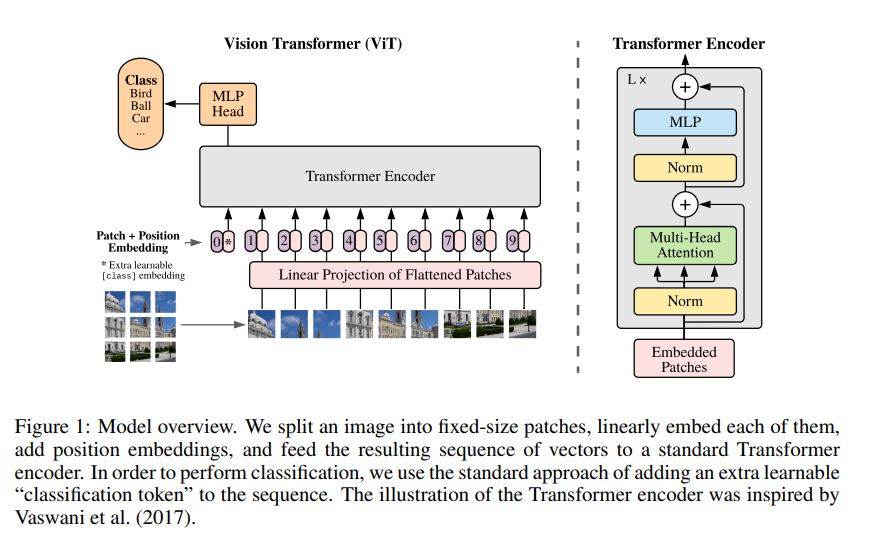

- ViT의 작동 과정은 5개의 Step으로 설명 가능합니다.

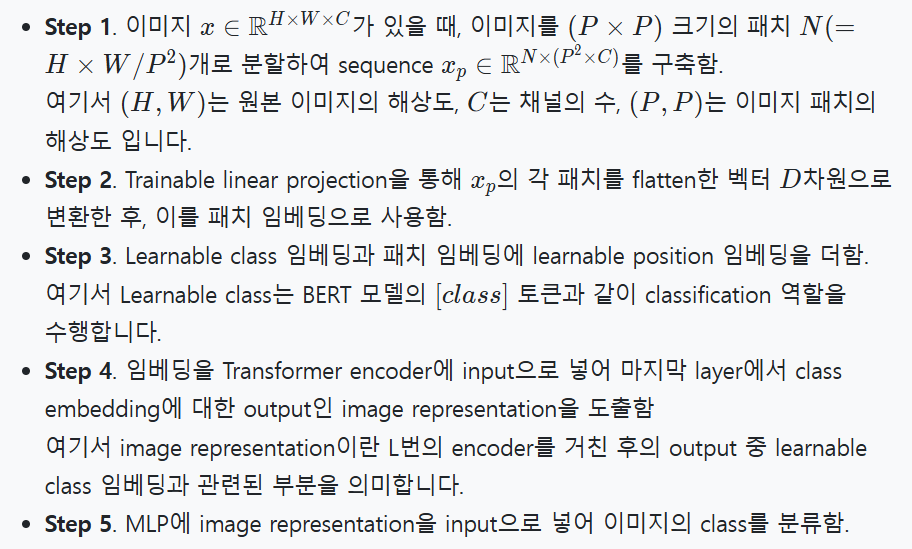

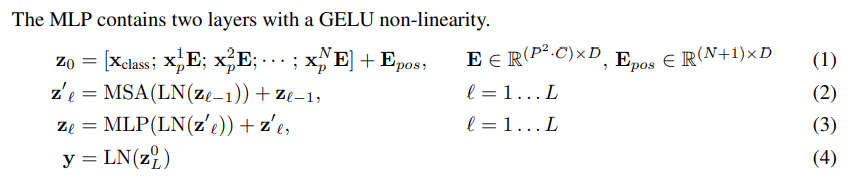

> Step 1~3까지는 (1)번 수식, Step 4는 (2), (3)번 수식, Step 5는 (4)번 수식과 연결된다.

> Inductive Bias
- ViT에서 MLP는 locality와 translation equivariance가 있습니다. 왜냐하면 이미지 패치를 sequential하게 잘라서 임베딩했기 때문입니다. 하지만 MSA는 global하기 때문에 CNN보다 image-specific inductive bias가 낮습니다.
따라서 ViT에서는 모델에 두가지 방법을 사용하여 inductive bias의 주입을 시도합니다.

- Patch extraction: cutting the image into patches
- Resolution adjustment: adjusing the position embeddings for images of diffrent resolution at fine-tuning

**Hybrid Architecture**

- ViT의 입력으로 raw image가 아닌 CNN으로 추출한 raw image의 feature map을 활용할 수 있다.
- Feature map은 이미 raw image의 공간적 정보를 포함하고 있으므로 패치를 자를 때 1x1로 설정해도 된다.
- 그렇게 한다면 feature map의 공간 차원을 flatten하여 각 벡터에 linear projection을 적용하면 된다.

**Fine-Tuning And Higher Resolution**

논문의 저자는 ViT를 large dataset으로 pre-train하고 downstream task에 fine-tune하여 사용한다.위와 같은 경우에는 pre-trained prediction head를 제거하고 D×K zero-initialized feedforward layer로 대체하면 된다. 대체가 이루어진다면 pre-training 시보다 더 높은 해상도를 fine-tune하는 것에 도움이 된다. 높은 해상도의 이미지를 모델에 적용한다면, patch size는 그대로 가져갈 것이고, 그렇다면 상당히 큰 sequence length를 갖게 된다.물론 ViT는 가변적 길이의 패치를 처리할 수는 있지만, pre-trained position embeddings는 의미를 잃게 됩니다. 이 경우 pre-trained position embedding을 원본 이미지의 위치에 따라 2D interpolation하면 된다.

## 3. Experiments

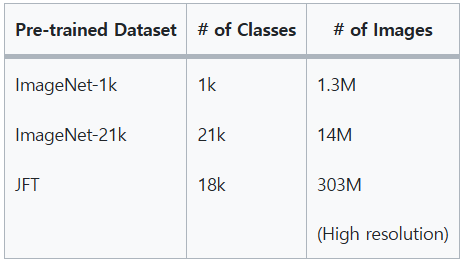

- ViT는 위와 같이 3개의 데이터셋으로 pre-train 된다.
- 그 후 이를 몇가지 benchmark tasks에 transfer 한다.

> model variant

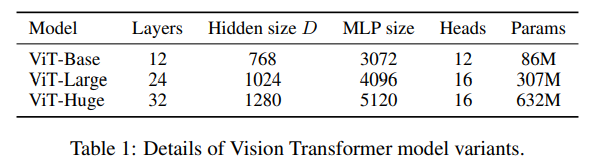

- ViT는 총 3개의 volume에 대해서 실험을 진행했으며, 각 볼륨에서도 다양한 패치 크기에 대해 실험을 진행했다.
- 여기서 Base와 Large 모델은 BERT 모델에서 직접적으로 채택했으며, Huge는 저자들이 추가한 것이다.

- 본 논문의 저자인 구글 팀은 이전 논문으로 transfer learning에 적합한 Big Transformer (BiT) 구조의 ResNet을 발표했다. 이는 batch normalization layer를 group normalization으로 변경하고 standardized convolutional leyer를 사용한 모델이다. 해당 모델을 비교군으로 삼아 실험을 진행한다.

**Metrics**

- 평가 지표로는 few-shot accuracy와 fine-tuning accuracy를 고려

- Few-shot accuracy: Training set에 없는 클래스를 맞추는 문제에 대한 정확도
- Fine-tuning accuracy: Fine-tuning 후의 정확도
- 본 논문의 저자는 fine-tuning의 성능에 집중하고 있기에 fine-tuning accuracy를 사용하지만 fine-tuning의 cost가 너무 크기 때문에 빠른 평가를 위해 때때로는 few-shot accuracies를 사용했다.



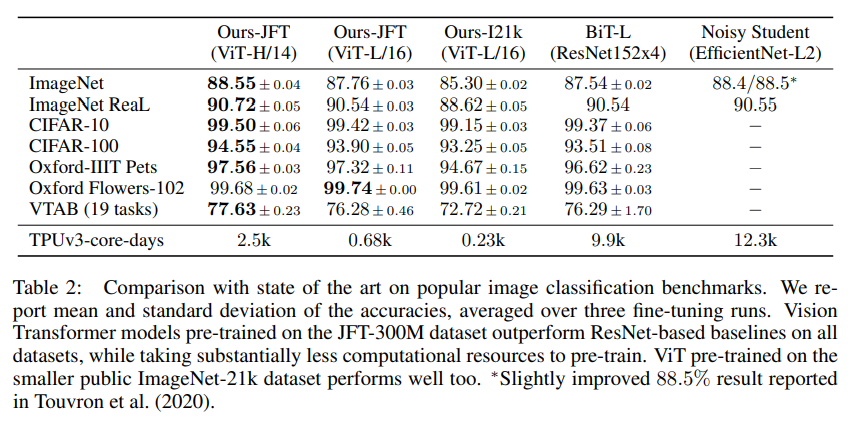

> 거의 모든 데이터셋에서 ViT-H/14 모델이 가장 높은 성능을 보였다. 이는 기존 SOTA 모델인 BiT-L 보다도 높은 성능이며 더 적은 시간이 걸렸다. 또한 주목할 점은 이보다 작은 모델인 ViT-L/16 또한 BiT-L보다 높은 성능을 보였으며 시간은 훨씬 적게 걸렸다.

## Inspecting Vision Transformer

결국은 ViT는 이미지를 처리하는 모델이기에 저자들은 시각적으로 어떻게 이미지를 처리하는지를 이해하기 위한 실험을 진행했다.

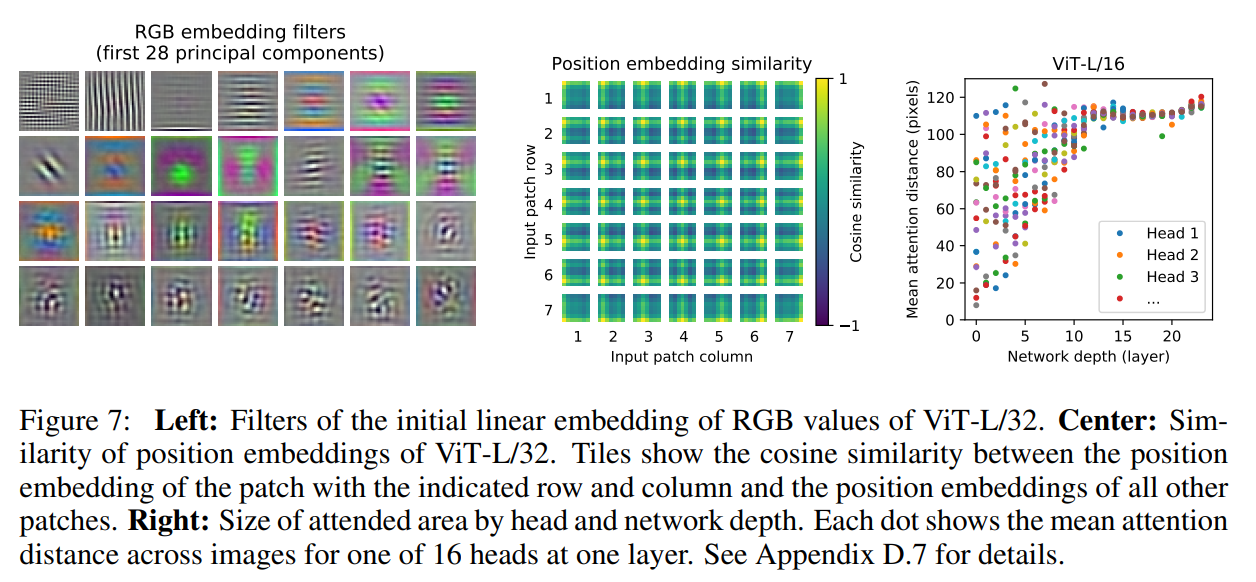

- 왼쪽부터 살펴보면, flatten된 패치를 패치 임베딩으로 변환하는 linear projection의 principal components를 분석한 모습이다. 이를 통해 저차원의 CNN Filter 기능과 유사하다는 것을 알 수 있다.
- 가운데를 살펴보면, 패치 간 position embedding의 유사도를 통해 가까운 위치에 있는 패치들의 position embedding이 유사한지를 확인하는 모습이다. 실제로 2D 이미지 모양대로 가까이 있는 패치들끼리 유사도가 높음을 확인할 수 있다.
- 오른쪽을 살펴보면, ViT의 layer별 평균 attention distance를 확인한 결과, 초반 layer에서도 attention을 통해 이미지 전체의 정보를 통합하여 사용함을 알 수 있다.

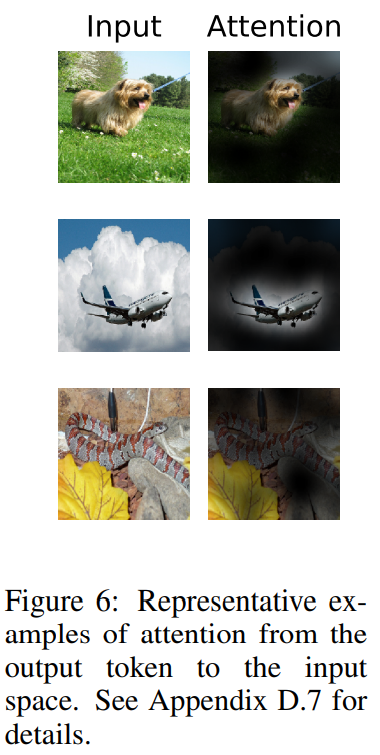

또한 attention을 사용한 만큼 task를 수행할 때 이미지의 어느 부분에 집중하는지를 파악할 수 있다.

##  Conclusion
- image-specific inductive biases를 특별하게 사용하지 않고, 이미지를 패치로 자른 sequence를 NLP에서 사용하는 Transformer encoder에 넣어서 self-attention을 사용함.

- 특히 large datasets으로 pre-train 시킴으로써 기존의 SOTA 모델들을 능가하는 성능과 더 적은 computational cost가 소요.

- 여전히 Challenge는 존재. 1. Detection과 Segmentation 2. Self-Supervised Learning